In [ ]:
import stats_functions as sf
import emission.storage.timeseries.aggregate_timeseries as estag
import emission.storage.timeseries.timequery as estt
import arrow
import numpy as np
import emission.core.get_database as edb
from emission.core.wrapper.user import User
import matplotlib.pyplot as plt
import pandas as pd
import uuid
from datetime import timedelta, date
import math
from scipy import stats

In [3]:
all_users = pd.DataFrame(list(edb.get_uuid_db().find({}, {"uuid": 1, "_id": 0})))
num_users = all_users.shape[0]
if num_users <= 0:
    raise Exception("No users in DB")

In [4]:
def calc_weeks(d1, d2):
    monday1 = (d1 - timedelta(days=d1.weekday()))
    monday2 = (d2 - timedelta(days=d2.weekday()))
    return int(math.floor((monday2 - monday1).days / 7))

In [ ]:
# Create a dataframe with columns user_id, carbon intensity, day, week number, and group (info/emotion).
df = pd.DataFrame()
    
for i in range(len(all_users)):
    user_id = all_users[i]
    
    # Determine group for the user.
    group = "none"
    try:
        client = edb.get_profile_db().find_one({"user_id": user_id})['client']
        if client == 'urap-2017-information':
            group = "information"
        elif client == 'urap-2017-emotion':
            group = "emotion"
        elif client == 'urap-2017-control':
            group = "control"
    except:
        continue
    
    start = arrow.get('2018-03-28', 'YYYY-MM-DD')
    end = arrow.get('2018-06-06', 'YYYY-MM-DD')
    for day in arrow.Arrow.range('day', start, end):
        begin_ts = day.timestamp
        end_ts = (day + timedelta(days=1)).timestamp
        val = User.computeCarbon(user_id, begin_ts, end_ts)
        if val != None:
            # Append a row to the df.
            week = calc_weeks(start, day)
            df = df.append({'uuid': user_id, 'carbon_intensity': val, 'week': week, 'group': group}, ignore_index=True)

In [ ]:
# Mean carbon intensity for each user.
mean_user_carbon_df = (df.groupby(['group' , 'uuid', 'week']).sum().reset_index()).drop('week', axis=1).groupby(['group' , 'uuid']).mean()
mean_user_carbon_df = mean_user_carbon_df.reset_index()
mean_user_carbon_df

In [ ]:
diff_df = pd.DataFrame()

# Only includes users with carbon intensities for more than one week.
curr_uuid = None
for index, row  in df.groupby(['group' , 'uuid', 'week']).sum().iterrows():
    curr_c_intensity = row['carbon_intensity']
    group = index[0]
    uuid = index[1]
    week = index[2]
    if curr_uuid == None:
        curr_uuid = uuid
    
    if uuid == curr_uuid:
        if week == 0:
            val = math.nan
        else:
            val = 100 * (curr_c_intensity - prev_c_intensity)/mean_user_carbon_df[mean_user_carbon_df.uuid == curr_uuid].iloc[0].carbon_intensity
            diff_df = diff_df.append({'uuid': uuid, 'carbon_intensity_diff (%)': val, 'week': week, 'group': group}, ignore_index=True)
    if uuid != curr_uuid:
        curr_uuid = uuid
    prev_c_intensity = curr_c_intensity
    

diff_df = diff_df[1:len(diff_df)]
diff_df

In [ ]:
# Averaged change in carbon intensity across users' weekly total carbon intensity.
mean_df = diff_df.groupby(['group' , 'uuid']).sum()
mean_df

In [9]:
df_group_change = mean_df.groupby(['group']).mean()
df_group_change

,carbon_intensity_diff (%),week
group,,
control,-25.525080,26.40
emotion,-74.039959,35.10
information,-120.275231,21.75


In [10]:
import numpy as np
df_group_change = mean_df.groupby(['group']).var()
print("control: ", np.var(mean_df.loc['control']))
print("emotion: ", np.var(mean_df.loc['emotion']))
print("information: ", np.var(mean_df.loc['information']))
df_group_change

control:  carbon_intensity_diff (%)    10360.591753
week                           339.240000
dtype: float64
emotion:  carbon_intensity_diff (%)    3587.880126
week                          396.690000
dtype: float64
information:  carbon_intensity_diff (%)    10401.234184
week                           344.687500
dtype: float64


,carbon_intensity_diff (%),week
group,,
control,11511.768615,376.933333
emotion,3986.533473,440.766667
information,11887.124782,393.928571


# Permutation Testing

In [ ]:
mean_df = mean_df.reset_index()

control_diff_simple_avg_df = mean_df.loc[mean_df.group == "control"]
emotion_diff_simple_avg_df = mean_df.loc[mean_df.group == "emotion"]
information_diff_simple_avg_df = mean_df.loc[mean_df.group == "information"]

control_emotion_diff_df = mean_df[mean_df.group != "information"]
control_information_diff_df = mean_df[mean_df.group != "emotion"]
emotion_information_diff_df = mean_df[mean_df.group != "control"]

control_emotion_diff_df

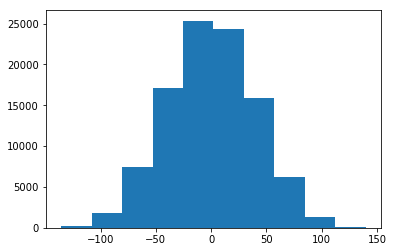

0.11561
Control vs Emotion


In [15]:
print(sf.perm_test(control_emotion_diff_df['group'], control_emotion_diff_df['carbon_intensity_diff (%)'], sf.mean_diff, 100000))
print("Control vs Emotion")

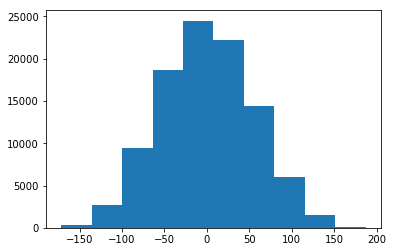

0.04265
Control vs Info


In [16]:
print(sf.perm_test(control_information_diff_df['group'], control_information_diff_df['carbon_intensity_diff (%)'], sf.mean_diff, 100000))
print("Control vs Info")

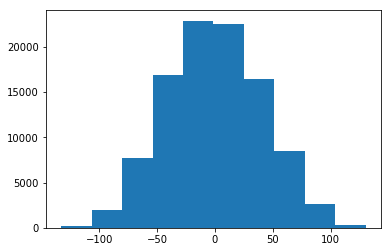

0.13937
Info vs Emotion


In [17]:
print(sf.perm_test(emotion_information_diff_df['group'], emotion_information_diff_df['carbon_intensity_diff (%)'], sf.mean_diff, 100000))
print("Info vs Emotion")

# Bootstrapping Tests

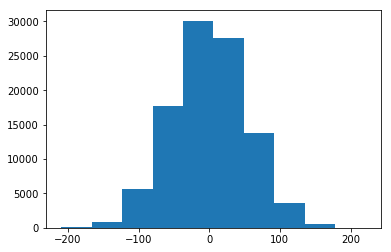

0.03808


In [19]:
print(sf.bootstrap_test(control_information_diff_df['group'], control_information_diff_df['carbon_intensity_diff (%)'], sf.mean_diff, 100000))

# Mann Whitney U Tests

In [20]:
from scipy.stats import mannwhitneyu

control = mean_df[mean_df['group'] == 'control']
control_array = control.as_matrix(columns=control.columns[2:])

info = mean_df[mean_df['group'] == 'information']
info_array = info.as_matrix(columns=info.columns[2:])

print(mannwhitneyu(info_array, control_array))

MannwhitneyuResult(statistic=12.0, pvalue=0.0072486744511082082)
